# Module 3 practice

In [1]:
## make sure rtweet is installed and added to lib path
source("../rlib.R")

## load rtweet and tidyverse
library(rtweet)
suppressPackageStartupMessages(library(tidyverse))

## 1. Search for the top account matching each of the following queries: fox news, msnbc, cnn

In [2]:
## search for users
foxnews <- search_users("fox news", n = 1, verbose = FALSE)
msnbc <- search_users("msnbc", n = 1, verbose = FALSE)
cnn <- search_users("cnn", n = 1, verbose = FALSE)

## 2. Retrieve up to 1,000 user IDs of accounts that follow @FoxNews on Twitter. 

In [3]:
## get followers
gop <- get_followers("FoxNews", n = 1000)

## 3. Retrieve up to 1,000 user IDs of accounts that follow @msnbc on Twitter

In [4]:
## get followers
dem <- get_followers("msnbc", n = 1000)

## 4. Retrieve up to 1,000 user IDs of accounts that follow @cnn on Twitter.

In [5]:
## get followers
mod <- get_followers("cnn", n = 1000)

## 5. Lookup users data for all 3,000 user IDs retrieved in the previous three questions.

In [6]:
## get gop users data
gop_data <- lookup_users(gop$user_id)

In [7]:
## get dem users data
dem_data <- lookup_users(dem$user_id)

In [8]:
## get mod users data
mod_data <- lookup_users(mod$user_id)

## 6. Using the data collected in the last question, add a 'partisan' variable, identifying the observations for each group as "gop" (Republican), "dem" (Democrat), or "mod" (moderate). Merge the data into a single data frame.

In [9]:
## create "partisan" grouping variable
gop_data$partisan <- "gop"
dem_data$partisan <- "dem"
mod_data$partisan <- "mod"

## merge into single data frame
data <- bind_rows(gop_data, dem_data, mod_data)

In [14]:
head(data,2)

user_id,name,screen_name,location,description,url,protected,followers_count,friends_count,listed_count,⋯,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,partisan
2986630051,Hank Yamamoto,hank2614,,,NA,FALSE,3,74,0,,3,2015-01-17 07:17:20,FALSE,NA,NA,ja,NA,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/940847417607499777/nR9u9P1P_normal.jpg,gop
1260912264,Lidice Ald<U+00E1>s,Lidicealdas64,Ecuador,"Concejal de Guayaquil por Alianza Pais, Zurda tiempo completo. Seguidora de Sabina, de la Pastorutti y de los amigos de siempre.",https://t.co/ZpkyPgVaJ7,FALSE,1510,774,4,,139,2013-03-12 02:40:38,FALSE,https://t.co/ZpkyPgVaJ7,https://www.facebook.com/LidiceAldas,es,https://pbs.twimg.com/profile_banners/1260912264/1513133515,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/900653132161658881/C-9QQsNj_normal.jpg,gop


## 7. Group by partisan [group] and summarise the mean number of friends and followers for each group. Print the summary data. 

In [10]:
## PRINT: group by partisan and summarise friends and followers counts
data %>%
    group_by(partisan) %>%
    summarise(
        friends = mean(friends_count, na.rm = TRUE),
        followers = mean(followers_count, na.rm = TRUE))

partisan,friends,followers
dem,828.190,3183.463
gop,188.604,263.757
mod,170.122,108.838


## 8. Plot the summary data you calculated in the previous question.

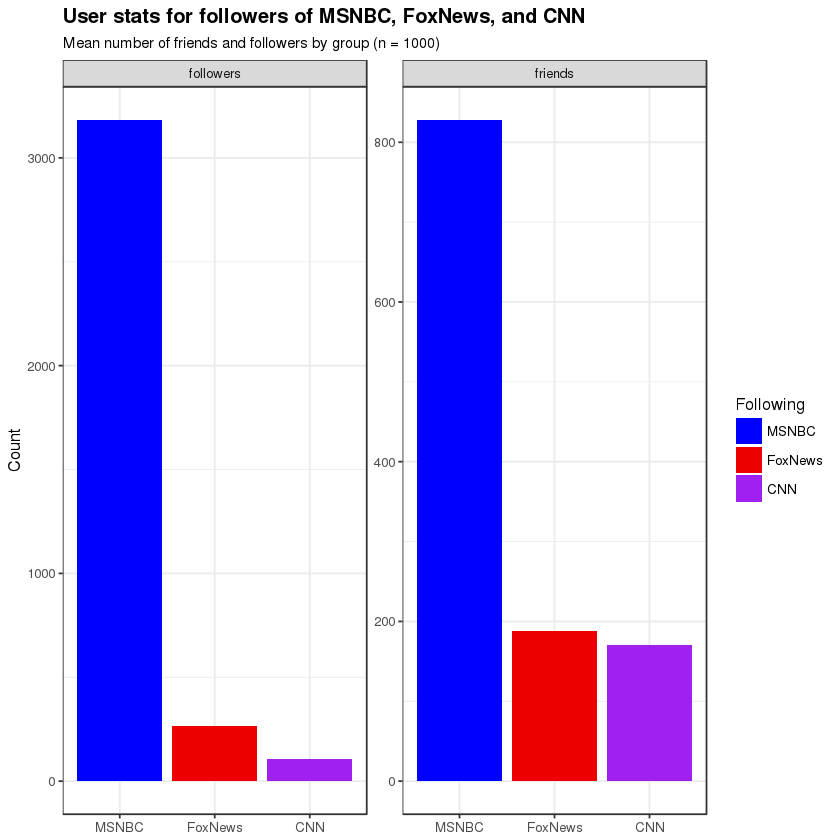

In [11]:
## PLOT: group by partisan and summarise integer vars
data %>%
    mutate(Following = factor(partisan, labels = c("MSNBC", "FoxNews", "CNN"))) %>%
    group_by(Following) %>%
    summarise(
        friends = mean(friends_count, na.rm = TRUE),
        followers = mean(followers_count, na.rm = TRUE)) %>%
    gather(var, count, -Following) %>%
    ggplot(aes(x = Following, y = count, fill = Following)) + 
    geom_col() + 
    facet_wrap(~ var, ncol = 2, scales = "free_y") + 
    theme_bw(base_size = 10) + 
    theme(plot.title = element_text(face = "bold")) + 
    scale_fill_manual(values = c(FoxNews = "red2", MSNBC = "blue", CNN = "purple")) + 
    labs(
        title = "User stats for followers of MSNBC, FoxNews, and CNN",
        subtitle = "Mean number of friends and followers by group (n = 1000)", 
        x = NULL, y = "Count")

## 9. From the data returned in the previous three questions, randomly select 5 users from each group (gop, dem, and mod). Prior to sampling, make sure to remove all users that (a) appear in more than one group or (b) have "protected" accounts. Combine all sampled users into a single data frame that includes a 'group' variable to identify each observation with its respective group (gop, dem, or mod).

In [12]:
## function to filter and then randomly sample user IDs
rsamp_uq <- function(..., n) {
    dots <- list(...)
    groups <- names(dots)
    user_ids <- lapply(dots, "[[", "user_id")
    for (i in seq_along(dots)) {
        ## filter out users found in other groups and protected users
        dots[[i]] <- filter(
            dots[[i]], 
            !user_id %in% unlist(user_ids[-i]) & !protected
        )
        dots[[i]]$group <- groups[i]
    }
    sample_users <- function(x, n) x[x$user_id %in% sample(x$user_id, n), ]
    out <- lapply(dots, sample_users, n)
    bind_rows(out)
}

## filter and sample 5 from each group
smps <- rsamp_uq(gop = gop_data, dem = dem_data, mod = mod_data, n = 5)

## 10. Get the friends of each account sampled in the previous question. Identify the top 3 accounts followed by users in each group and then print a frequency table with their screen names.

In [13]:
## get friends for each sampled user
fds <- lapply(smps$user_id, get_friends, verbose = FALSE)

## add the list of data frames to smps as a list column
smps$fds <- I(fds)

## create function to identify the top 3 accounts and then lookup their screen names
get_top_names <- function(x, n = 3) {
    tbl <- sort(table(unlist(x)), decreasing = TRUE)
    if (length(tbl) > n) {
        tbl <- tbl[seq_len(n)]
    }
    sns <- lookup_users(names(tbl))
    sns$screen_name
}

## print out top 3 screen names associated with each group
smps %>% 
    group_by(group) %>%
    summarise(
        freq = list(get_top_names(fds))
    )

group,freq
dem,"ogtrekkie, amsgarcia, lorabk"
gop,"AshleyRange3 , andy4neli , JasonWa52902467"
mod,"muhammadbelal78, Azimk112 , Kojo_CFC"
